# Why not measure distances from learned weights?

Angular loss is calculated against model weights.
Model weights is handled as a vector that represents a class, then this learned weights should become center of class sample vectors.

Here's tried with MVTec AD' Screw class example, compared each resulting AUCs between one that calculates distanse from learned weight - class center, and another that calculates distance from a closest training sample.

## Result

Using distance from closest training sample is confirmed empirically to be the better, consistently.

This would be easy to explain, and we might even prove mathematically.

| Test No. | AUC with closest sample | AUC with class weight |
|---------|--------------------------|-----------------------|
| 1st | 0.735 | 0.727 |
| 2nd | 0.876 | 0.859 |
| 3rd | 0.725 | 0.625 |


In [1]:
import sys; sys.path.append('..')
from mvtecad_test import *
from fastai.callbacks import SaveModelCallback
from PIL import ImageFilter

VISUALIZE = True
PATH = Path('/mnt/dataset/mvtec_ad')

class DefectOnBlobImageList(AnomalyTwinImageList):
    BLOB_TH = 20
    WIDTH_MIN = 1
    WIDTH_MAX = 14
    LENGTH_MAX = 30
    COLOR = True

    @classmethod
    def set_params(cls, blob_th=20, width_min=1, width_max=14, length=225//5, color=True):
        cls.BLOB_TH = blob_th
        cls.WIDTH_MIN, cls.WIDTH_MAX = width_min, width_max
        cls.LENGTH_MAX, cls.COLOR = length, color

    def anomaly_twin(self, image):
        """Default anomaly twin maker."""
        np_img = np.array(image.filter(ImageFilter.SMOOTH)).astype(np.float32)
        scar_max = self.LENGTH_MAX
        half = self.SIZE // 2
        # Randomly choose point on object blob
        ys, xs = np.where(np.sum(np.abs(np.diff(np_img, axis=0)), axis=2) > self.BLOB_TH)
        x = random.choice(xs)
        ys_x = ys[np.where(xs == x)[0]]
        y = random.randint(ys_x.min(), ys_x.max())
        # Randomly choose other parameters
        dx, dy = random.randint(0, scar_max), random.randint(0, scar_max)
        x2, y2 = x + dx if x < half else x - dx, y + dy if y < half else y - dy
        c = (random.randint(0, 256), random.randint(0, 224), random.randint(0, 256))
        if not self.COLOR: c = (c[0], c[0], c[0])
        w = random.randint(self.WIDTH_MIN, self.WIDTH_MAX)
        ImageDraw.Draw(image).line((x, y, x2,y2), fill=c, width=w)
        return image

# 'capsule',
mvtecad = MVTecADTest(PATH, artificial_image_list_cls=DefectOnBlobImageList,
                      testcases = [ 'screw',], img_size=224)#, skip_data_creation=True)
DefectOnBlobImageList.set_params(blob_th=20, width_min=1, width_max=16, length=30, color=False)

# Test: case0-0-screw-manipulated_front
['train/good', 'train/manipulated_front']
['test/scratch_neck', 'test/good', 'test/manipulated_front', 'test/scratch_head', 'test/thread_top', 'test/thread_side']

# Test: case0-1-screw-scratch_head
['train/good', 'train/scratch_head']
['test/scratch_neck', 'test/good', 'test/manipulated_front', 'test/scratch_head', 'test/thread_top', 'test/thread_side']

# Test: case0-2-screw-scratch_neck
['train/scratch_neck', 'train/good']
['test/scratch_neck', 'test/good', 'test/manipulated_front', 'test/scratch_head', 'test/thread_top', 'test/thread_side']

# Test: case0-3-screw-thread_side
['train/good', 'train/thread_side']
['test/scratch_neck', 'test/good', 'test/manipulated_front', 'test/scratch_head', 'test/thread_top', 'test/thread_side']

# Test: case0-4-screw-thread_top
['train/good', 'train/thread_top']
['test/scratch_neck', 'test/good', 'test/manipulated_front', 'test/scratch_head', 'test/thread_top', 'test/thread_side']



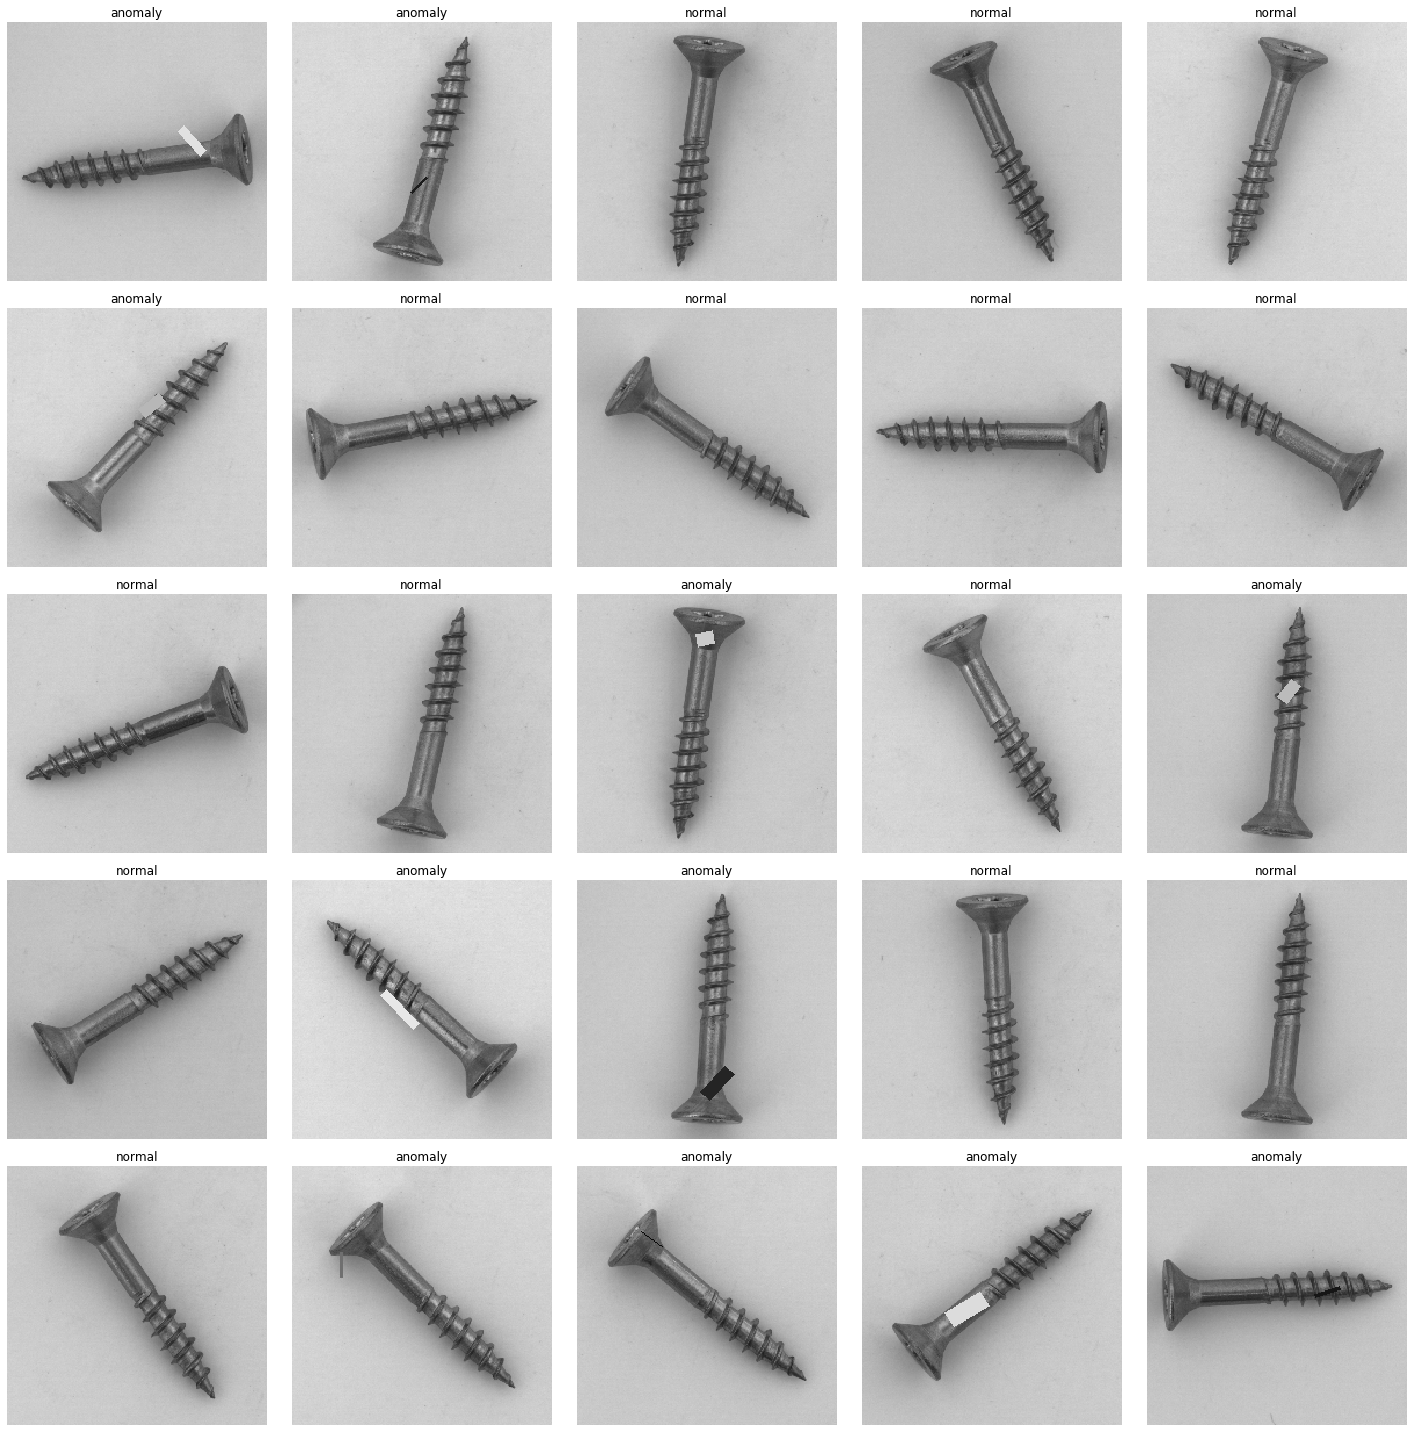

In [2]:
mvtecad.set_test(0, 0)
data = mvtecad.databunch()
data.show_batch()

In [3]:
def learner_ArcFace(data):
    learn = cnn_learner(data, models.resnet34, metrics=accuracy)
    learn.model = XFaceNet(learn.model, data, ArcMarginProduct, m=0.2) # <<===
    learn.callback_fns.append(partial(LabelCatcher))
    learn.fit_one_cycle(10, max_lr=1e-2)
    learn.fit_one_cycle(10, max_lr=1e-4)
    learn.unfreeze()
    learn.fit_one_cycle(20, max_lr=slice(1e-6, 1e-5), callbacks=[SaveModelCallback(learn)])
    return learn

mvtecad.set_test(0, 0)
data = mvtecad.databunch()
learn = learner_ArcFace(data)

epoch,train_loss,valid_loss,accuracy,time
0,5.824239,1.445971,0.539062,00:03
1,5.125512,2.455929,0.640625,00:02
2,4.632843,5.264138,0.578125,00:02
3,4.228378,6.084724,0.507812,00:02
4,3.798850,3.670752,0.593750,00:02
5,3.524944,2.066574,0.750000,00:02
6,3.207543,1.047919,0.851562,00:02
7,2.972302,1.501348,0.765625,00:02
8,2.737461,1.298229,0.820312,00:02
9,2.599410,1.800908,0.835938,00:02


epoch,train_loss,valid_loss,accuracy,time
0,2.098549,1.678901,0.812500,00:02
1,2.000992,1.070795,0.898438,00:02
2,1.905311,1.712999,0.859375,00:02
3,1.715835,1.531946,0.890625,00:02
4,1.713582,1.218497,0.898438,00:02
5,1.686348,0.974031,0.914062,00:02
6,1.652515,1.118508,0.898438,00:02
7,1.649519,1.450980,0.898438,00:02
8,1.626524,1.672038,0.898438,00:02
9,1.538858,1.198856,0.890625,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.692309,1.622608,0.859375,00:03
1,1.484231,1.640643,0.882812,00:03
2,1.465101,2.289927,0.851562,00:03
3,1.473906,1.494412,0.890625,00:03
4,1.495395,1.440588,0.882812,00:03
5,1.494355,1.264425,0.890625,00:03
6,1.521228,1.452394,0.890625,00:03
7,1.516219,1.863934,0.843750,00:03
8,1.478021,0.914297,0.898438,00:03
9,1.433362,0.777749,0.921875,00:03


Better model found at epoch 0 with valid_loss value: 1.622607946395874.
Better model found at epoch 3 with valid_loss value: 1.4944121837615967.
Better model found at epoch 4 with valid_loss value: 1.4405879974365234.
Better model found at epoch 5 with valid_loss value: 1.2644248008728027.
Better model found at epoch 8 with valid_loss value: 0.9142967462539673.
Better model found at epoch 9 with valid_loss value: 0.7777488231658936.
Better model found at epoch 18 with valid_loss value: 0.5251455307006836.


In [4]:
anomaly_data = data
self = mvtecad
case_no = 0
if True:
    # Get embeddings for both test/train samples.
    eval_test_ds, eval_test_dl = self.eval_ds_dl('test')
    eval_train_ds, eval_train_dl = self.eval_ds_dl(learn.data.train_ds.path)
    test_embs,  test_y  = get_embeddings(body_feature_model(learn.model), eval_test_dl, return_y=True)
    train_embs, train_y = get_embeddings(body_feature_model(learn.model), eval_train_dl, return_y=True)

    # Calculate distances from the training (all normal) samples to the test samples.
    distances = n_by_m_distances(test_embs, train_embs, how=self.distance)
    print(f'Calculated distances in shape (test x train) = {distances.shape}')

    # Get basic values
    test_anomaly_mask = [y != eval_test_ds.classes.index('good') for y in test_y]
    test_anomaly_idx = np.where(test_anomaly_mask)[0]
    y_true = np.array(list(map(int, test_anomaly_mask)))
    preds = self.pred_fn(distances, axis=1)

    fpr, tpr, thresholds = metrics.roc_curve(y_true, preds)
    auc = metrics.auc(fpr, tpr)
auc

Calculated distances in shape (test x train) = (160, 320)


0.7351916376306621

In [5]:
if True:
    # Get normal center vector, which is learned by mergin fc layer.
    fc = list(learn.model.children())[1][-1].metric_fc
    normal_center = fc.weight[learn.data.classes.index('normal')].cpu().detach().numpy()

    # Calculate distances from class center.
    norm_test = test_embs / np.linalg.norm(test_embs, axis=1).reshape(-1, 1)
    norm_cntr = normal_center / np.linalg.norm(normal_center)
    cntr_preds = 1 - (norm_test @ norm_cntr)

    c_fpr, c_tpr, c_thresholds = metrics.roc_curve(y_true, cntr_preds)
    c_auc = metrics.auc(c_fpr, c_tpr)
c_auc #list(cntr_preds)

0.7274031563845049

## 2nd try

In [6]:
mvtecad.set_test(0, 0)
data = mvtecad.databunch()
learn = learner_ArcFace(data)

epoch,train_loss,valid_loss,accuracy,time
0,5.948650,1.157903,0.593750,00:02
1,5.268225,1.666908,0.773438,00:02
2,4.687113,4.061262,0.593750,00:02
3,4.328617,1.851682,0.734375,00:02
4,3.922704,2.701761,0.750000,00:02
5,3.637044,2.052346,0.656250,00:02
6,3.368316,3.005174,0.632812,00:02
7,3.076067,1.275029,0.796875,00:02
8,2.809075,0.930699,0.875000,00:02
9,2.638634,1.035485,0.890625,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.589440,1.107276,0.882812,00:02
1,1.702474,1.338051,0.882812,00:02
2,1.670344,1.706719,0.828125,00:02
3,1.635833,0.922471,0.921875,00:02
4,1.598790,1.472880,0.875000,00:02
5,1.665404,1.472791,0.867188,00:02
6,1.627327,1.485424,0.851562,00:02
7,1.592466,1.438237,0.898438,00:02
8,1.523676,1.077829,0.898438,00:02
9,1.564748,1.237105,0.882812,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.904613,1.014964,0.882812,00:03
1,1.846929,1.656922,0.828125,00:03
2,1.807196,1.499595,0.882812,00:03
3,1.667513,1.769863,0.843750,00:03
4,1.630267,1.708388,0.851562,00:03
5,1.584815,1.042216,0.906250,00:03
6,1.529553,1.023904,0.906250,00:03
7,1.531387,1.343742,0.882812,00:03
8,1.519721,1.867937,0.843750,00:03
9,1.560384,0.924401,0.929688,00:03


Better model found at epoch 0 with valid_loss value: 1.0149643421173096.
Better model found at epoch 9 with valid_loss value: 0.9244009256362915.
Better model found at epoch 19 with valid_loss value: 0.9154921770095825.


In [7]:
anomaly_data = data
self = mvtecad
case_no = 0
if True:
    # Get embeddings for both test/train samples.
    eval_test_ds, eval_test_dl = self.eval_ds_dl('test')
    eval_train_ds, eval_train_dl = self.eval_ds_dl(learn.data.train_ds.path)
    test_embs,  test_y  = get_embeddings(body_feature_model(learn.model), eval_test_dl, return_y=True)
    train_embs, train_y = get_embeddings(body_feature_model(learn.model), eval_train_dl, return_y=True)

    # Calculate distances from the training (all normal) samples to the test samples.
    distances = n_by_m_distances(test_embs, train_embs, how=self.distance)
    print(f'Calculated distances in shape (test x train) = {distances.shape}')

    # Get basic values
    test_anomaly_mask = [y != eval_test_ds.classes.index('good') for y in test_y]
    test_anomaly_idx = np.where(test_anomaly_mask)[0]
    y_true = np.array(list(map(int, test_anomaly_mask)))
    preds = self.pred_fn(distances, axis=1)

    fpr, tpr, thresholds = metrics.roc_curve(y_true, preds)
    auc = metrics.auc(fpr, tpr)
auc

Calculated distances in shape (test x train) = (160, 320)


0.8759991801598689

In [8]:
if True:
    # Get normal center vector, which is learned by mergin fc layer.
    fc = list(learn.model.children())[1][-1].metric_fc
    normal_center = fc.weight[learn.data.classes.index('normal')].cpu().detach().numpy()

    # Calculate distances from class center.
    norm_test = test_embs / np.linalg.norm(test_embs, axis=1).reshape(-1, 1)
    norm_cntr = normal_center / np.linalg.norm(normal_center)
    cntr_preds = 1 - (norm_test @ norm_cntr)

    c_fpr, c_tpr, c_thresholds = metrics.roc_curve(y_true, cntr_preds)
    c_auc = metrics.auc(c_fpr, c_tpr)
c_auc #list(cntr_preds)

0.8589874974379996

## 3rd try

In [9]:
mvtecad.set_test(0, 0)
data = mvtecad.databunch()
learn = learner_ArcFace(data)

epoch,train_loss,valid_loss,accuracy,time
0,6.048970,2.913571,0.500000,00:02
1,5.342679,3.611358,0.632812,00:02
2,4.875613,2.633137,0.718750,00:02
3,4.449863,1.422988,0.789062,00:02
4,4.033523,3.727715,0.640625,00:03
5,3.610126,3.124651,0.617188,00:02
6,3.297055,3.084526,0.671875,00:02
7,2.994804,1.192184,0.765625,00:02
8,2.683724,1.403437,0.820312,00:02
9,2.569638,1.090032,0.867188,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.842335,1.515518,0.875000,00:02
1,1.636992,1.304260,0.890625,00:02
2,1.674662,0.883577,0.921875,00:02
3,1.622249,1.143157,0.906250,00:02
4,1.578183,1.601600,0.882812,00:02
5,1.558442,2.083196,0.820312,00:02
6,1.538164,1.438559,0.890625,00:02
7,1.512872,1.626130,0.859375,00:02
8,1.525904,1.437192,0.859375,00:02
9,1.590481,1.106246,0.890625,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.661468,1.768794,0.890625,00:03
1,1.435493,1.387390,0.890625,00:03
2,1.429847,2.014612,0.835938,00:03
3,1.477762,0.826869,0.921875,00:03
4,1.469815,0.840353,0.945312,00:03
5,1.448923,1.408389,0.890625,00:04
6,1.398239,1.536429,0.898438,00:03
7,1.453817,1.521714,0.875000,00:03
8,1.429940,1.079063,0.929688,00:03
9,1.438003,1.271853,0.906250,00:03


Better model found at epoch 0 with valid_loss value: 1.768794059753418.
Better model found at epoch 1 with valid_loss value: 1.38739013671875.
Better model found at epoch 3 with valid_loss value: 0.8268693685531616.
Better model found at epoch 12 with valid_loss value: 0.7757949829101562.
Better model found at epoch 18 with valid_loss value: 0.5944786667823792.


In [10]:
anomaly_data = data
self = mvtecad
case_no = 0
if True:
    # Get embeddings for both test/train samples.
    eval_test_ds, eval_test_dl = self.eval_ds_dl('test')
    eval_train_ds, eval_train_dl = self.eval_ds_dl(learn.data.train_ds.path)
    test_embs,  test_y  = get_embeddings(body_feature_model(learn.model), eval_test_dl, return_y=True)
    train_embs, train_y = get_embeddings(body_feature_model(learn.model), eval_train_dl, return_y=True)

    # Calculate distances from the training (all normal) samples to the test samples.
    distances = n_by_m_distances(test_embs, train_embs, how=self.distance)
    print(f'Calculated distances in shape (test x train) = {distances.shape}')

    # Get basic values
    test_anomaly_mask = [y != eval_test_ds.classes.index('good') for y in test_y]
    test_anomaly_idx = np.where(test_anomaly_mask)[0]
    y_true = np.array(list(map(int, test_anomaly_mask)))
    preds = self.pred_fn(distances, axis=1)

    fpr, tpr, thresholds = metrics.roc_curve(y_true, preds)
    auc = metrics.auc(fpr, tpr)
auc

Calculated distances in shape (test x train) = (160, 320)


0.7251485960237753

In [11]:
if True:
    # Get normal center vector, which is learned by mergin fc layer.
    fc = list(learn.model.children())[1][-1].metric_fc
    normal_center = fc.weight[learn.data.classes.index('normal')].cpu().detach().numpy()

    # Calculate distances from class center.
    norm_test = test_embs / np.linalg.norm(test_embs, axis=1).reshape(-1, 1)
    norm_cntr = normal_center / np.linalg.norm(normal_center)
    cntr_preds = 1 - (norm_test @ norm_cntr)

    c_fpr, c_tpr, c_thresholds = metrics.roc_curve(y_true, cntr_preds)
    c_auc = metrics.auc(c_fpr, c_tpr)
c_auc #list(cntr_preds)

0.6253330600532896